**Table of contents**<a id='toc0_'></a>    
- 1. [select channel](#toc1_)    
- 2. [Function definitions](#toc2_)    
- 3. [load pkl files](#toc3_)    
- 4. [concatenate catalogues](#toc4_)    
- 5. [Exploratory Analysis](#toc5_)    
- 6. [Data Cleaning](#toc6_)    
- 7. [Extract fit_param into dict](#toc7_)    
- 8. [Investigating Paramater distributions](#toc8_)    
  - 8.1. [t0](#toc8_1_)    
  - 8.2. [$\sigma$](#toc8_2_)    
    - 8.2.1. [fitting](#toc8_2_1_)    
  - 8.3. [$\tau$](#toc8_3_)    
  - 8.4. [scale](#toc8_4_)    
- 9. [Cuts:  rectangular cut](#toc9_)    
  - 9.1. [$ \sigma$](#toc9_1_)    
    - 9.1.1. [fitting](#toc9_1_1_)    
  - 9.2. [$\tau$](#toc9_2_)    
    - 9.2.1. [fitting](#toc9_2_1_)    
    - 9.2.2. [Fitting with iMinuit](#toc9_2_2_)    
  - 9.3. [scale](#toc9_3_)    
    - 9.3.1. [fitting](#toc9_3_1_)    
- 10. [FingerPlot](#toc10_)    
- 11. [fit gaussian to finger](#toc11_)    
  - 11.1. [First finger](#toc11_1_)    
  - 11.2. [Second finger](#toc11_2_)    
- 12. [SPE charge](#toc12_)    
- 13. [SNR](#toc13_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import pickle
import matplotlib.pyplot as plt
from matplotlib import legend
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as patches
import matplotlib.offsetbox as offsetbox
import matplotlib as mpl

In [2]:
mpl.rcParams['axes.labelsize'] = 14

In [3]:
np.set_printoptions(formatter={'float': lambda x: f"{x:10.4g}"})

In [4]:
%matplotlib ipympl

# 1. <a id='toc1_'></a>[select channel](#toc0_)

Which channel?

In [5]:
ch_str_ls = ['ch0', 'ch1', 'ch2']

# selected_channel =  input("Choose channel number for processing.")
selected_channel = 0
print(f"selected channel index: {selected_channel}")
ch_x = ch_str_ls[int(selected_channel)]

selected channel index: 0


# 2. <a id='toc2_'></a>[Function definitions](#toc0_)

In [6]:
def f_gauss(x, g_mean, g_sigma, g_k):
    return g_k*(1/(g_sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-g_mean)/g_sigma)**2)

In [7]:
def red_chisq(f_obs, f_exp, fittedparameters):
    chisqr = np.sum((f_obs - f_exp)**2 / f_exp)
    ndf = f_obs.shape[0]
    return chisqr/(ndf -fittedparameters.shape[0])

# 3. <a id='toc3_'></a>[load pkl files](#toc0_)

In [8]:
# all_clean_catalogues = []
# for run_number in run_number_ls:
#     all_clean_catalogues.append(f'clean_catalogue_run000{run_number}.pkl')

In [9]:
# selected_clean_catalogue_path = os.path.join(output_folder, all_clean_catalogues[3])
# selected_clean_dict = pickle.load(open(selected_fit_catalogue_path, 'rb'))
# selected_clean_dict #['ch2']

In [9]:
# output_folder = '/home/sarthak/my_projects/argset/output_folder/'
output_folder = '/work/chuck/sarthak/argset/output_folder'
# output_folder = '/work/sarthak/argset/processed_data/backup_ch2/'
# output_folder = '/work/sarthak/argset/processed_data/backup/'
# output_folder = '/work/chuck/sarthak/argset/backup_default_ARMA/output_folder/'

In [10]:
run_number_ls = [52, 53, 54, 61, 62, 63]
# run_number_ls = [52, 61]

In [11]:
all_fit_catalogues = []
for run_number in run_number_ls:
    # all_fit_catalogues.append(f'{output_folder}/fit_catalogue_run000{run_number}.pkl')
    # all_fit_catalogues.append(f'{output_folder}/fit_catalogue_custom_run000{run_number}.pkl')
    all_fit_catalogues.append(f'{output_folder}/fit_catalogue_filteredWF_run000{run_number}.pkl')

In [12]:
all_fit_catalogues

['/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00052.pkl',
 '/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00053.pkl',
 '/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00054.pkl',
 '/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00061.pkl',
 '/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00062.pkl',
 '/work/chuck/sarthak/argset/output_folder/fit_catalogue_filteredWF_run00063.pkl']

In [13]:
fit_dict_52 = pickle.load(open( all_fit_catalogues[0], 'rb'))

In [14]:
fit_dict_53 = pickle.load(open( all_fit_catalogues[1], 'rb'))

In [15]:
fit_dict_54 = pickle.load(open( all_fit_catalogues[2], 'rb'))

In [16]:
fit_dict_61 = pickle.load(open( all_fit_catalogues[3], 'rb'))

In [17]:
fit_dict_62 = pickle.load(open( all_fit_catalogues[4], 'rb'))

In [18]:
fit_dict_63 = pickle.load(open( all_fit_catalogues[4], 'rb'))

# 4. <a id='toc4_'></a>[concatenate catalogues](#toc0_)

In [19]:
fit_dict_ls = [fit_dict_52, fit_dict_53, fit_dict_54, fit_dict_61, fit_dict_62, fit_dict_63]
# fit_dict_ls = [fit_dict_52, fit_dict_53, fit_dict_54]
# fit_dict_ls = [fit_dict_61, fit_dict_62, fit_dict_63]
# ch_str_ls = ['ch0', 'ch1', 'ch2'] # original
ch_str_ls = [['ch0', 'ch1', 'ch2'][selected_channel]]
# ch_str_ls = ['ch2']

fit_catalogue = {}
# for ch_x in ch_str_ls: # original
for ch_x in ch_str_ls:
    fit_catalogue_x = []
    for fit_dict in fit_dict_ls:
        fit_catalogue_x.append(fit_dict[ch_x])
    fit_catalogue[ch_x] = pd.concat(fit_catalogue_x, ignore_index=True)

Free up RAM

In [21]:
del fit_dict_52, fit_dict_53, fit_dict_54, fit_dict_61, fit_dict_62, fit_dict_63

<p> Note: remember event_counter is unique only for a run; for concatenated DataFrames it is no longer unique identifier.</p>

# 5. <a id='toc5_'></a>[Exploratory Analysis](#toc0_)
No longer needed!

the ratio of good fit waveforms to clean forms

In [22]:
# (fit_catalogue['ch0'][fit_catalogue['ch0']['chisqr']< 2.0]).shape[0]/(fit_catalogue['ch0']).shape[0]

In [23]:
# (fit_catalogue['ch1'][fit_catalogue['ch1']['chisqr']< 2.0]).shape[0]/(fit_catalogue['ch1']).shape[0]

In [24]:
# (fit_catalogue['ch2'][fit_catalogue[ch_x]['chisqr']< 2.0]).shape[0]/(fit_catalogue['ch2']).shape[0]

How many times fit failed to converge?

In [25]:
# fit_catalogue['ch0']['fit_param'].isnull().sum()

In [26]:
# fit_catalogue['ch1']['fit_param'].isnull().sum()

In [27]:
# fit_catalogue['ch2']['fit_param'].isnull().sum()

In [28]:
# fit_catalogue['ch0'].index.values.shape

In [29]:
# fit_catalogue['ch0'][fit_catalogue['ch0']['chisqr']< 2.0]

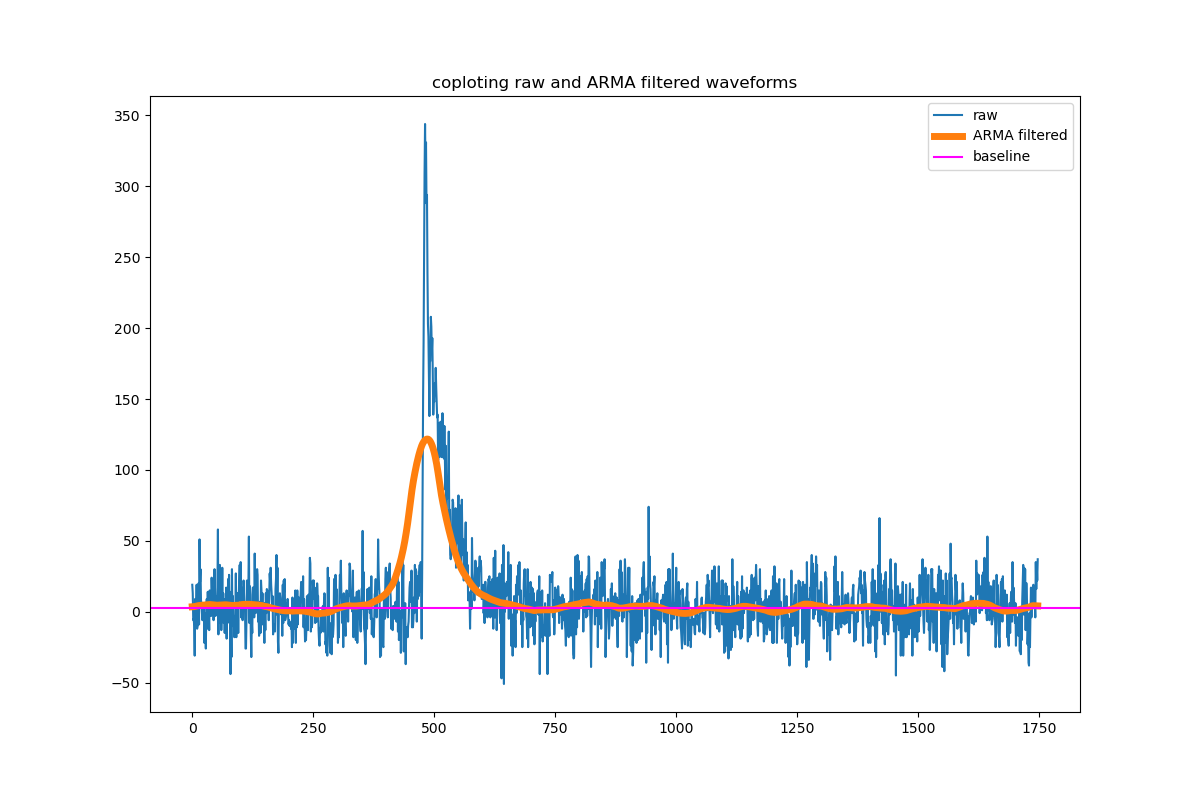

In [60]:
plt.figure(figsize=(12, 8))
plt.title('coploting raw and ARMA filtered waveforms')

event_value = 35

# plt.plot(fit_dict_52['ch0']['wf_ch0'][event_value], label='raw + shift')
plt.plot(fit_dict_52['ch0']['wf_raw'][event_value], label='raw')
plt.plot(fit_dict_52['ch0']['filtered_wf_ch0'][event_value], linewidth=5, label='ARMA filtered')
plt.axhline(y=fit_dict_52['ch0']['fit_param'][event_value][4], color='magenta', label = 'baseline')
plt.legend()

# 6. <a id='toc6_'></a>[Data Cleaning](#toc0_)

Drop NA rows

In [21]:
for ch_index in ch_str_ls:
    fit_catalogue[ch_index] = fit_catalogue[ch_index].dropna()

In [32]:
# sanity check: dropna works!
# fit_catalogue['ch0']['fit_param'].isnull().sum()

# 7. <a id='toc7_'></a>[Extract fit_param into dict](#toc0_)

extracting param values

In [22]:
param_dict = {}
for ch_index in ch_str_ls:
    t0_ls = []
    sigma_ls = []
    tau_ls = []
    scale_ls = []
    fit_param_x = {}
    for loop_index in fit_catalogue[ch_index].index.values:
        loop_fit_param = fit_catalogue[ch_index].loc[loop_index]['fit_param']
        t0_ls.append(loop_fit_param[0])
        sigma_ls.append(loop_fit_param[1])
        tau_ls.append(loop_fit_param[2])
        scale_ls.append(loop_fit_param[3])
    fit_param_x['t0'] = t0_ls
    fit_param_x['sigma'] = sigma_ls
    fit_param_x['tau'] = tau_ls
    fit_param_x['scale'] = scale_ls
    param_dict[ch_index] = fit_param_x

# 8. <a id='toc8_'></a>[Investigating Paramater distributions](#toc0_)

## 8.1. <a id='toc8_1_'></a>[t0](#toc0_)

Text(0.5, 1.0, 't0')

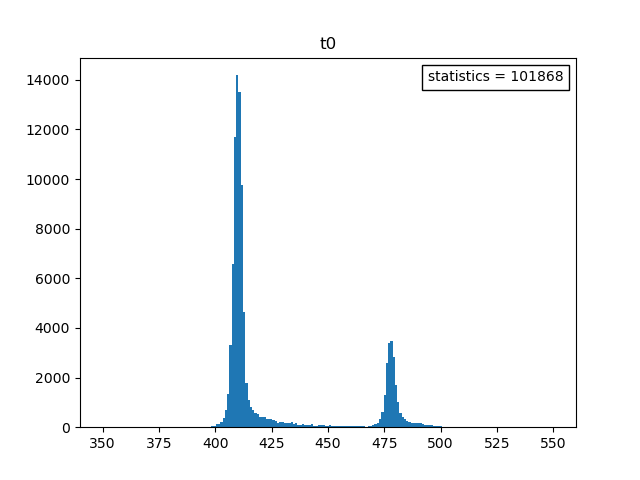

In [23]:
plt.close(1)
fig1, ax1 = plt.subplots()
text_in_box = AnchoredText(f"statistics = {len(param_dict[ch_x]['t0'])}", \
                                       loc='upper right')
ax1.add_artist(text_in_box)
ax1.hist(param_dict[ch_x]['t0'], bins = np.linspace(350, 550, 200))
ax1.set_title('t0')

## 8.2. <a id='toc8_2_'></a>[$\sigma$](#toc0_)

Text(0.5, 1.0, '$\\sigma$')

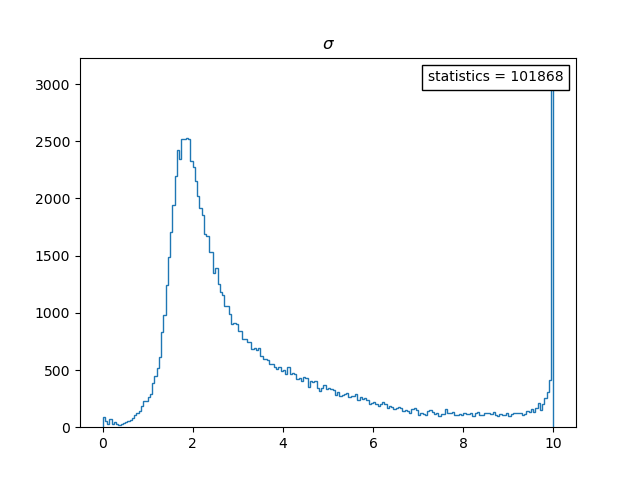

In [24]:
plt.close(2)
fig2, ax2 = plt.subplots()
hist_content, hist_edges, _hist_obj= ax2.hist(param_dict[ch_x]['sigma'], bins=200, histtype='step', label = 'data') #, bins= np.linspace(1.0, 6.0, 10))
text_in_box = AnchoredText(f"statistics = {len(param_dict[ch_x]['sigma'])}", \
                                       loc='upper right')
ax2.add_artist(text_in_box)
ax2.set_title('$\\sigma$')

### 8.2.1. <a id='toc8_2_1_'></a>[fitting](#toc0_)

In [25]:
x_range = range(30, 49)

p0_input = [2, 0.45, 500.0] ## ch2 & ch1

# bounds_input = ([1.0, 0.0, 500.0], [10.0, 1.0, 600.0]) ## ch2
bounds_input = ([1.0, 0.0, 0.0], [10.0, 1.0, np.inf]) ## ch1

fitted_parameters, _pcov = curve_fit(f_gauss, 
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input, 
                            bounds = bounds_input,
                            sigma = np.sqrt(hist_content[x_range]),
                            absolute_sigma=True,
                            )

chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters), fitted_parameters
    )

ax2.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters), 
        #  color='red', 
         label='fitted function')
ax2.legend()
chisqr_in_box = AnchoredText(f"red. chisqr = {chisqr_value:.2f}", \
                                       loc='center right')
ax2.add_artist(chisqr_in_box)

chisqr_value

7.30030054492982

In [26]:
fitted_parameters

array([     1.853,     0.5026,       3061])

In [27]:
legend_obj_ax2 = ax2.legend(loc='best', bbox_to_anchor=[1.0, 0.90])

In [39]:
# legend.DraggableLegend(legend_obj_ax2)

In [40]:
# pickle.dump( (fig2, ax2), open('ax2_plot.pkl', 'wb')) ## writes plot to file

## 8.3. <a id='toc8_3_'></a>[$\tau$](#toc0_)

Text(0.5, 1.0, '$\\tau$')

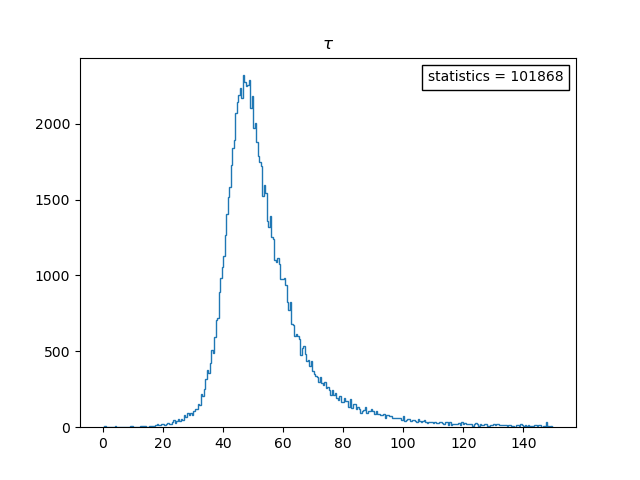

In [28]:
plt.close(3)
fig3, ax3 = plt.subplots()
ax3.hist = plt.hist(param_dict[ch_x]['tau'], bins= np.linspace(0.0, 150.0, 300), histtype='step')
text_in_box = AnchoredText(f"statistics = {len(param_dict[ch_x]['tau'])}", \
                                       loc='upper right')
ax3.add_artist(text_in_box)
ax3.set_title('$\\tau$')

## 8.4. <a id='toc8_4_'></a>[scale](#toc0_)

Text(0.5, 1.0, 'scale')

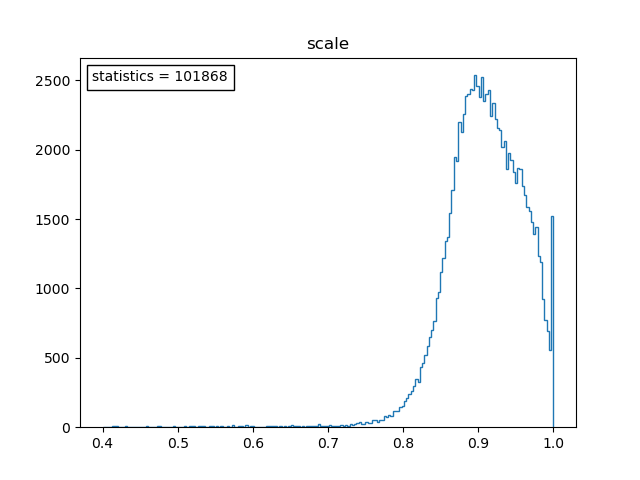

In [29]:
plt.close(4)
fig4, ax4 = plt.subplots()
ax4.hist(param_dict[ch_x]['scale'], bins= np.linspace(0.4, 1.0, 200), histtype='step')
text_in_box = AnchoredText(f"statistics = {len(param_dict[ch_x]['scale'])}", \
                                       loc='upper left')
ax4.add_artist(text_in_box)
ax4.set_title('scale')

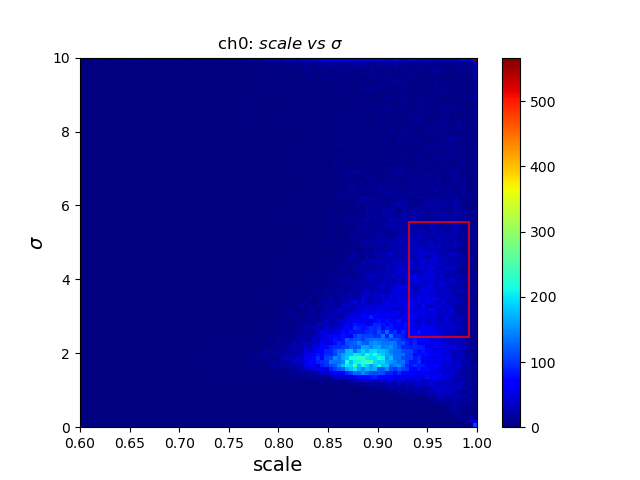

In [30]:
plt.close(5)

red_win = patches.Rectangle((0.932, 2.44), 0.06, 3.10, linewidth=1.1, edgecolor='r', facecolor='none')
fig5, ax5 = plt.subplots()
hist_h, hist_xedges, hist_yedges, hist_im = ax5.hist2d(param_dict[ch_x]['scale'], \
                    param_dict[ch_x]['sigma'], bins = [np.linspace(0.6, 1.0, 100), np.linspace(0., 10., 100)], \
                    cmap='jet')
ax5.add_patch(red_win)
ax5.set_xlabel('scale')
ax5.set_ylabel('$\sigma$')
fig5.colorbar(hist_im)
ax5.set_title(f' {ch_x}: $scale\ vs \ \\sigma$');

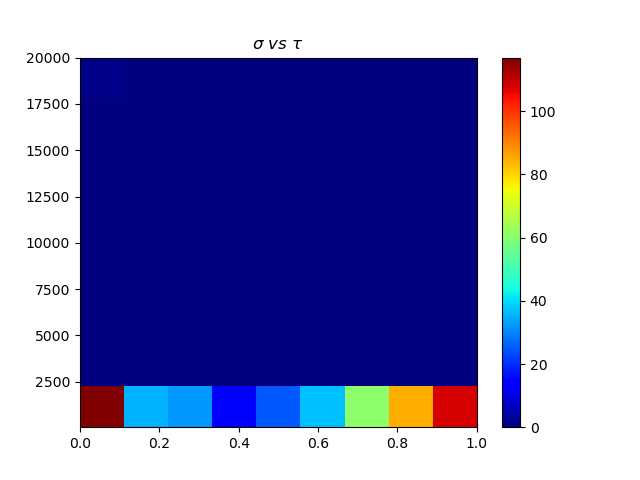

In [31]:
plt.close(6)
fig6, ax6 = plt.subplots()
hist_h, hist_xedges, hist_yedges, hist_im = ax6.hist2d(param_dict[ch_x]['sigma'], \
                    param_dict[ch_x]['tau'], bins = [np.linspace(0.0, 1.0, 10), np.linspace(50e0, 20e3, 10)] , \
                        cmap='jet')
fig6.colorbar(hist_im)
ax6.set_title('$\\sigma \ vs \ \\tau $');

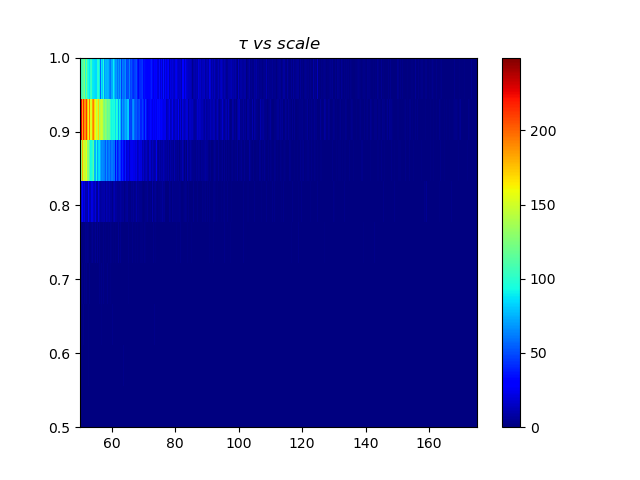

In [32]:
plt.close(7)
fig7, ax7 = plt.subplots()
hist_h, hist_xedges, hist_yedges, hist_im = ax7.hist2d(param_dict[ch_x]['tau'], \
                    param_dict[ch_x]['scale'], bins = [np.linspace(50, 175, 1000), np.linspace(0.5, 1.0, 10)], \
                    cmap='jet')
fig7.colorbar(hist_im)
ax7.set_title('$\\tau \ vs \ scale $');

# 9. <a id='toc9_'></a>[Cuts:  rectangular cut](#toc0_)

<span style='color:green'> List of events to be removed</span>

In [33]:
### list of events which contribute to red window for Ch2
internal_points = []
for fit_index in fit_catalogue[ch_x].index.values:
    loop_fit_param = fit_catalogue[ch_x]['fit_param'].loc[fit_index]
    param_point = (loop_fit_param[3], loop_fit_param[1]) # scale, sigma
    transformed_interior_point = red_win.get_data_transform().transform(param_point)
    if red_win.contains_point(transformed_interior_point, radius=0):
        internal_points.append(fit_index)

<span style = 'color:green'> Exploratory Analysis on red window: </span>

In [34]:
internal_points;

In [35]:
all_indices = fit_catalogue[ch_x].index.values

In [36]:
all_indices[1000] in internal_points

False

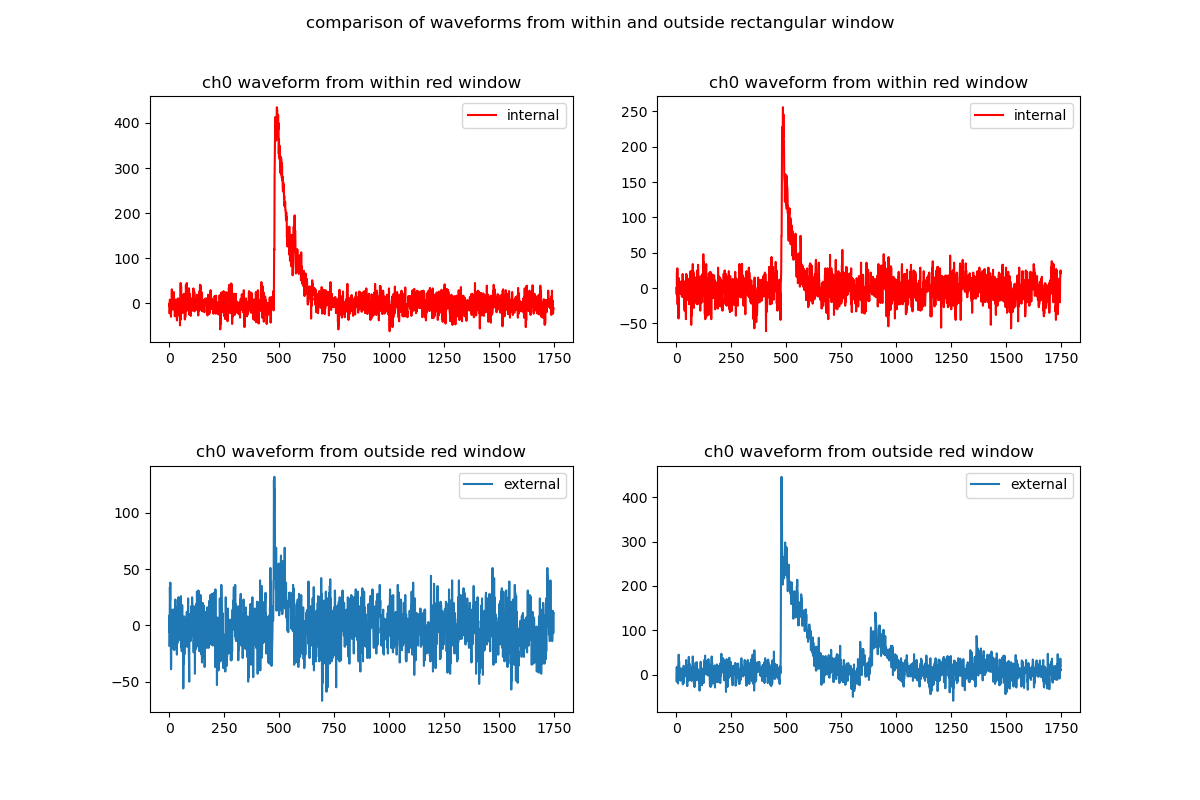

In [37]:
fig555, ax555 = plt.subplots(2, 2, figsize=(12, 8))

selected_internal_wf = fit_catalogue[ch_x]['wf_raw'][internal_points[20]]

ax555[0][0].plot(selected_internal_wf, label = 'internal', color='red')
ax555[0][0].set_title(f"{ch_x} waveform from within red window")

selected_internal_wf = fit_catalogue[ch_x]['wf_raw'][internal_points[999]]

ax555[0][1].plot(selected_internal_wf, label = 'internal', color='red')
ax555[0][1].set_title(f"{ch_x} waveform from within red window")

selected_external_wf = fit_catalogue[ch_x]['wf_raw'][all_indices[100]]

ax555[1][0].plot(selected_external_wf, label = 'external')
ax555[1][0].set_title(f"{ch_x} waveform from outside red window")

selected_external_wf = fit_catalogue[ch_x]['wf_raw'][all_indices[1000]]

ax555[1][1].plot(selected_external_wf, label = 'external')
ax555[1][1].set_title(f"{ch_x} waveform from outside red window")

ax555[0][0].legend()
ax555[0][1].legend()
ax555[1][0].legend()
ax555[1][1].legend()

fig555.suptitle("comparison of waveforms from within and outside rectangular window")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.50)
# fig555.tight_layout()
# text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['t0'])}", \
#                                        loc='upper right')
# ax555.add_artist(text_in_box)

<span style='color:green'> applying cut </span>

In [38]:
fit_catalogue[ch_x] = fit_catalogue[ch_x].drop(index = internal_points)

<span style='color:green'> extracting param_dict out of DataFrames for all channels </span>

In [39]:
param_dict_cut = {}
for ch_index in ch_str_ls:
# for ch_x in ['ch2']: #ch_str_ls:
    t0_ls = []
    sigma_ls = []
    tau_ls = []
    scale_ls = []
    fit_param_x = {}
    for loop_index in fit_catalogue[ch_index].index.values:
        loop_fit_param = fit_catalogue[ch_index].loc[loop_index]['fit_param']
        t0_ls.append(loop_fit_param[0])
        sigma_ls.append(loop_fit_param[1])
        tau_ls.append(loop_fit_param[2])
        scale_ls.append(loop_fit_param[3])
    fit_param_x['t0'] = t0_ls
    fit_param_x['sigma'] = sigma_ls
    fit_param_x['tau'] = tau_ls
    fit_param_x['scale'] = scale_ls
    param_dict_cut[ch_index] = fit_param_x

In [40]:
# selected_channel = input("enter channel number")
ch_x = ch_str_ls[int(selected_channel)]
# ch_x = 'ch2'

Text(0.5, 1.0, 'ch0 t0: patch removed')

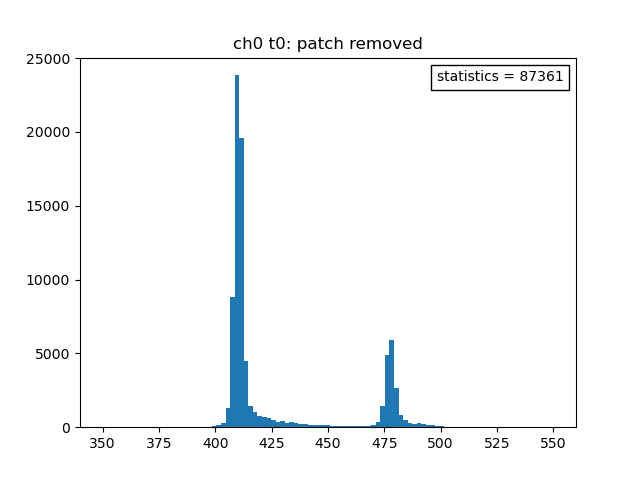

In [41]:
plt.close(22)
fig22, ax22 = plt.subplots()
text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['t0'])}", \
                                       loc='upper right')
ax22.add_artist(text_in_box)
ax22.hist(param_dict_cut[ch_x]['t0'], bins = np.linspace(350, 550, 100))
ax22.set_title(f"{ch_x} t0: patch removed")

## 9.1. <a id='toc9_1_'></a>[$ \sigma$](#toc0_)

<ErrorbarContainer object of 3 artists>

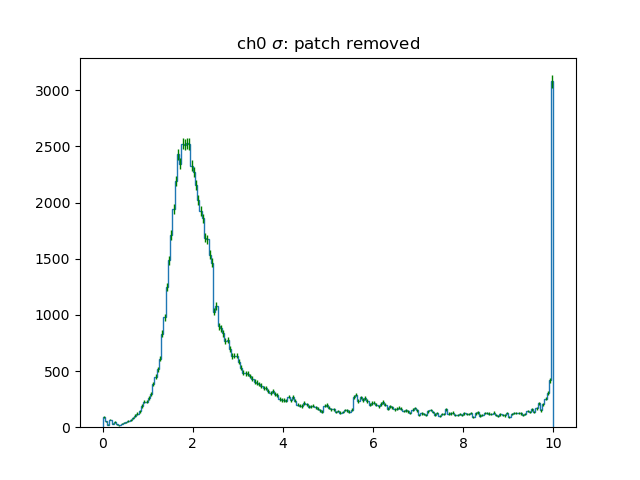

In [42]:
plt.close(23)
fig23, ax23 = plt.subplots()
hist_content, hist_edges, _hist_obj= ax23.hist(param_dict_cut[ch_x]['sigma'], bins=200, histtype='step', label='sigma') #, bins= np.linspace(1.0, 6.0, 10))
# text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['sigma'])}", \
                                    #    loc='lower right')
# ax23.add_artist(text_in_box)
ax23.set_title(f"{ch_x} $\\sigma$: patch removed")
## error bars
hist_centers = []
for i in range(hist_edges.shape[0]):
    center_variable = np.mean(hist_edges[i:i+2])
    hist_centers.append(center_variable)

hist_centers = np.array(hist_centers)

ax23.errorbar(hist_centers[:hist_content.shape[0]], hist_content, \
              yerr = np.sqrt(hist_content), elinewidth=1.0, linestyle='none', ecolor='green')

### 9.1.1. <a id='toc9_1_1_'></a>[fitting](#toc0_)

In [43]:
# x_range # ch1 & ch2
# x_range = [range(24, 40), range(30, 49), range(30, 49)][selected_channel] ##ch0
x_range = [range(24, 40), range(24, 41), range(30, 49)][selected_channel]

p0_input = [2, 0.45, 500.0]
bounds_input = ([1.50, 0.0, 0.0], [2.15, 1.0, np.inf])

fitted_parameters_sigma, _pcov = curve_fit(f_gauss, 
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input, 
                            sigma = np.sqrt(hist_content[x_range]),
                            absolute_sigma=True,
                            bounds = bounds_input,
                            )

ax23.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters_sigma), \
          color='red', label='fitted function')

ax23.legend()

chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters_sigma), fitted_parameters_sigma
    )

text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['sigma'])} \nred. chisqr = {chisqr_value:.2f}", \
                                       loc='center right')
ax23.add_artist(text_in_box)

fitted_parameters_sigma

array([       1.8,       0.33,       2129])

## 9.2. <a id='toc9_2_'></a>[$\tau$](#toc0_)

<ErrorbarContainer object of 3 artists>

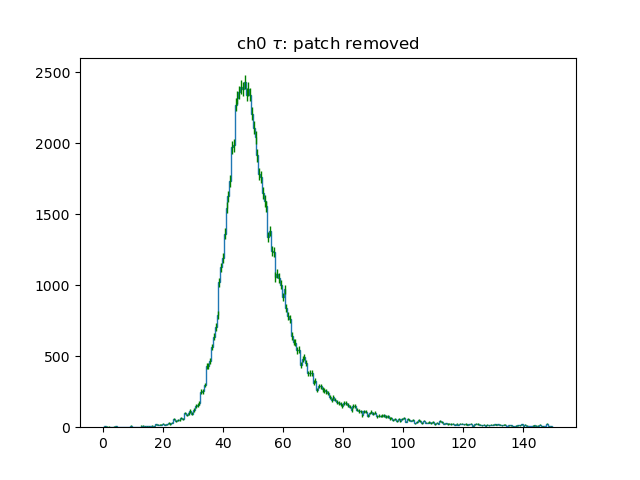

In [44]:
# ch_x = 'ch2'
plt.close(24)
fig24, ax24 = plt.subplots()
hist_content, hist_edges, _hist_obj = ax24.hist(param_dict_cut[ch_x]['tau'], bins= np.linspace(0.0, 150.0, 250), histtype='step')
# text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['tau'])}", \
#                                        loc='upper right')
# ax24.add_artist(text_in_box)
ax24.set_title(f"{ch_x} $\\tau$: patch removed")

##error bars
hist_centers = []
for i in range(hist_edges.shape[0]):
    center_variable = np.mean(hist_edges[i:i+2])
    hist_centers.append(center_variable)

hist_centers = np.array(hist_centers)

ax24.errorbar(hist_centers[:hist_content.shape[0]], hist_content, yerr = np.sqrt(hist_content), elinewidth=1.0, linestyle='none', ecolor='green')

### 9.2.1. <a id='toc9_2_1_'></a>[fitting](#toc0_)

In [45]:
# x_range = range(58, 91) # ch0,1,2
x_range = range(58, 73) # ch0

p0_input = [50.0, 9.0, 8000.0] # ch1 & ch2
# bounds_input = ([20.0, 0.05, 1.0], [60.0, 15.5, 10_000]) ## ch2
bounds_input = ([20.0, 0.05, 1.0], [60.0, 15.5, np.inf]) ## ch0,1,2

fitted_parameters_tau, _pcov = curve_fit(f_gauss, \
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input, \
                            bounds = bounds_input, \
                            sigma = np.sqrt(hist_content[x_range]), \
                            absolute_sigma=True, \
                            # x_scale = [10, 1, 1000], \
                            method = 'trf', \
                            ## method = 'dogbox', \
                            )

### plotting
ax24.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters_tau), color='red', label='fitted function')
# ax24.legend(loc='upper right')

chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters_tau), fitted_parameters_tau
    )

text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['tau'])} \nred. chisqr = {chisqr_value:.2f}", \
                                       loc='center right')

ax24.add_artist(text_in_box)
fitted_parameters_tau

array([      48.2,      6.856,  4.474e+04])

### 9.2.2. <a id='toc9_2_2_'></a>[Fitting with iMinuit](#toc0_)
Only used for verifying scipy fitter

In [59]:
# import iminuit
# from iminuit.cost import LeastSquares
# from iminuit import Minuit

In [60]:
# least_squares = LeastSquares(x_values[58:91], hist_content[58:91], np.sqrt(hist_content[58:91]), f_gauss)
# # least_squares = LeastSquares(x_values, hist_content[:x_values.shape[0]], np.ones(x_values.shape[0]), f_gauss)

In [61]:
# m_obj = Minuit(least_squares, g_mean = 50.0, g_sigma = 9.5, g_k = 8000)

In [62]:
# m_obj.simplex()

In [63]:
# m_obj.migrad()

## 9.3. <a id='toc9_3_'></a>[scale](#toc0_)

Text(0.5, 1.0, 'ch0 scale: patch removed')

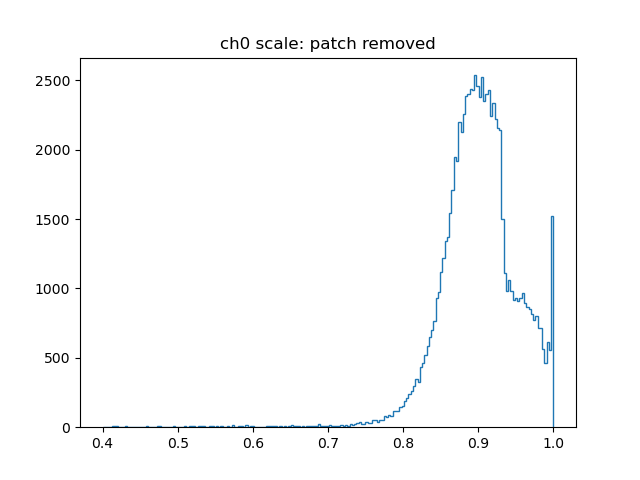

In [46]:
# ch_x = 'ch2'
plt.close(25)
fig25, ax25 = plt.subplots()
hist_content, hist_edges, _hist_obj = ax25.hist(param_dict_cut[ch_x]['scale'], \
                                                bins= np.linspace(0.4, 1.0, 200), histtype='step', label='data')
# text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['scale'])}", \
#                                        loc='upper left')
# ax25.add_artist(text_in_box)
ax25.set_title(f"{ch_x} scale: patch removed")

### 9.3.1. <a id='toc9_3_1_'></a>[fitting](#toc0_)

In [47]:
# x_range = [range(153, 172), range(130, 172), range(130, 172)][selected_channel] #range(130, 177) 160 165 # ch2
x_range = [range(157, 169), range(138, 157), range(130, 172)][selected_channel]

## x_range = range(153, 172) # ch0
p0_input = [0.89, 0.09, 200.0]
bounds_input = ([0.8, 0.01, 1.0], [1.0, 1.0, 10_000])

fitted_parameters_scale, _pcov = curve_fit(f_gauss, \
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input, \
                            bounds = bounds_input, \
                            sigma = np.sqrt(hist_content[x_range]), \
                            absolute_sigma=True, \
                            # x_scale = [10, 1, 1000], \
                            method = 'trf', \
                            ## method = 'dogbox', \
                            )
##error bars
hist_centers = []
for i in range(hist_edges.shape[0]):
    center_variable = np.mean(hist_edges[i:i+2])
    hist_centers.append(center_variable)

hist_centers = np.array(hist_centers)

ax25.errorbar(hist_centers[:hist_content.shape[0]], hist_content, \
              yerr = np.sqrt(hist_content), elinewidth=1.0, linestyle='none', ecolor='green')
### plotting
ax25.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters_scale), \
          color='red', label='fitted function')
ax25.axvline(x = 0.9026)
# ax25.legend(loc='lower left')

chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters_scale), fitted_parameters_scale
    )

print(f'chisqr_value: {chisqr_value}')
print(f'fitted_parameters_scale: {fitted_parameters_scale}')

text_in_box = AnchoredText(f"statistics = {len(param_dict_cut[ch_x]['scale'])} \nred. chisqr = {chisqr_value:.2f}", \
                                       loc='center left')

ax25.add_artist(text_in_box)

chisqr_value: 1.669007651558048
fitted_parameters_scale: [    0.8957    0.04102      254.2]


2d parameter space 

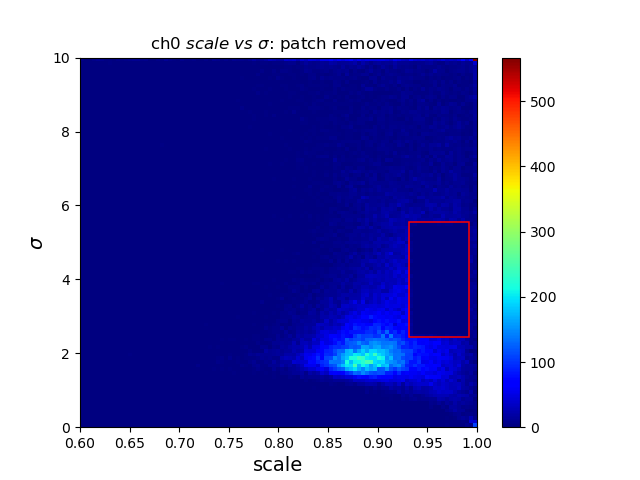

In [48]:
# ch_x = 'ch2'
plt.close(26)
fig26, ax26 = plt.subplots()
red_win = patches.Rectangle((0.932, 2.44), 0.06, 3.10, linewidth=1.1, edgecolor='r', facecolor='none')

hist_h, hist_xedges, hist_yedges, hist_im = ax26.hist2d(param_dict_cut[ch_x]['scale'], param_dict_cut[ch_x]['sigma'], \
           bins = [np.linspace(0.6, 1.0, 100), np.linspace(0., 10., 100)], cmap='jet')
ax26.add_patch(red_win)
ax26.set_xlabel('scale')
ax26.set_ylabel('$\sigma$')
fig26.colorbar(hist_im)
ax26.set_title(f"{ch_x} $scale\ vs \ \\sigma$: patch removed");

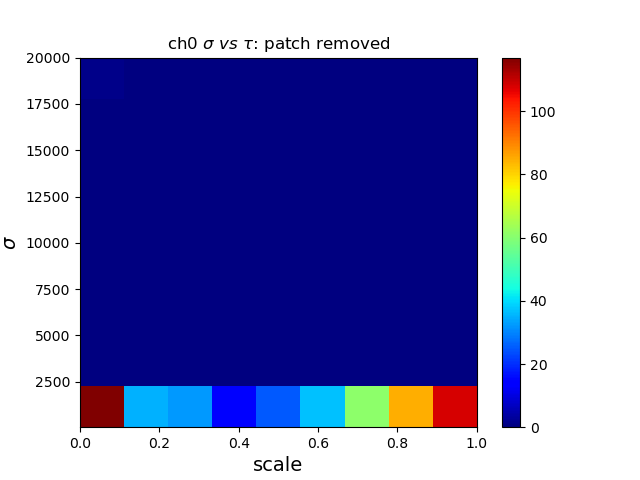

In [49]:
# ch_x = 'ch2'
plt.close(27)
fig27, ax27 = plt.subplots()
hist_h, hist_xedges, hist_yedges, hist_im = ax27.hist2d(param_dict_cut[ch_x]['sigma'], param_dict_cut[ch_x]['tau'], \
           bins = [np.linspace(0.0, 1.0, 10), np.linspace(50e0, 20e3, 10)] , cmap='jet')
ax27.set_xlabel('scale')
ax27.set_ylabel('$\sigma$')
fig27.colorbar(hist_im)
ax27.set_title(f"{ch_x} $\\sigma \ vs \ \\tau $: patch removed");

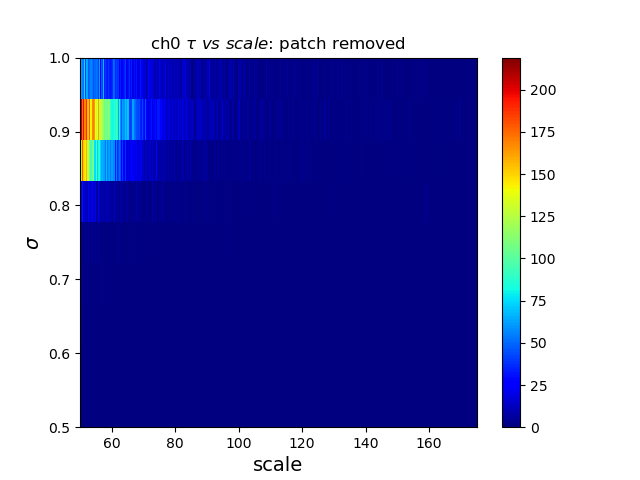

In [50]:
# ch_x = 'ch2'
plt.close(28)
fig28, ax28 = plt.subplots()
hist_h, hist_xedges, hist_yedges, hist_im = ax28.hist2d(param_dict_cut[ch_x]['tau'], \
            param_dict_cut[ch_x]['scale'], bins = [np.linspace(50, 175, 1000), np.linspace(0.5, 1.0, 10)] ,\
            cmap='jet')

ax28.set_xlabel('scale')
ax28.set_ylabel('$\sigma$')
fig28.colorbar(hist_im)
ax28.set_title(f"{ch_x} $\\tau \ vs \ scale $: patch removed");

# 10. <a id='toc10_'></a>[FingerPlot](#toc0_)

1

In [78]:
fit_catalogue['ch0'] #TODO invetigate

,event_counter,wf_ch0,wf_raw,filtered_wf_ch0,fit_param,chisqr
0,13.0,"[42.0, 74.0, 71.0, 65.0, 76.0, 51.0, 62.0, 61....","[-16.0, 16.0, 13.0, 7.0, 18.0, -7.0, 4.0, 3.0,...","[9.412471964717708, 9.394299182445689, 9.39218...","[476.3364806510814, 2.2653064623586343, 68.373...",5.229966
3,79.0,"[113.0, 97.0, 114.0, 115.0, 112.0, 113.0, 115....","[55.0, 39.0, 56.0, 57.0, 54.0, 55.0, 57.0, 40....","[133.31940361833023, 133.46158938032283, 133.8...","[67.00055658690563, 6.52517521480628, 67.01008...",14.035644
4,89.0,"[93.0, 37.0, 65.0, 97.0, 60.0, 86.0, 73.0, 50....","[36.0, -20.0, 8.0, 40.0, 3.0, 29.0, 16.0, -7.0...","[2.143022697653323, 2.141228706484601, 2.13405...","[476.77589990584534, 1.5328653243715287, 55.76...",5.009394
5,164.0,"[59.0, 54.0, 45.0, 49.0, 59.0, 41.0, 59.0, 40....","[2.0, -3.0, -12.0, -8.0, 2.0, -16.0, 2.0, -17....","[-9.284361960852097, -9.296956393972547, -9.28...","[477.3596476627071, 2.6850373213116434, 48.543...",4.872091
6,165.0,"[46.0, 71.0, 61.0, 87.0, 88.0, 72.0, 79.0, 55....","[-13.0, 12.0, 2.0, 28.0, 29.0, 13.0, 20.0, -4....","[6.938723810546294, 6.914342853314, 6.88695812...","[477.0000229167873, 2.89719456003637, 68.02144...",4.629526
...,...,...,...,...,...,...
102110,99983.0,"[30.0, 22.0, 42.0, 37.0, 52.0, 42.0, 62.0, 35....","[-23.0, -31.0, -11.0, -16.0, -1.0, -11.0, 9.0,...","[3.3439049421848486, 3.3535892197951838, 3.362...","[405.99998915164514, 6.015212965800255, 46.483...",4.672340
102111,99991.0,"[57.0, 66.0, 37.0, 34.0, 70.0, 57.0, 76.0, 69....","[3.0, 12.0, -17.0, -20.0, 16.0, 3.0, 22.0, 15....","[4.545110928924163, 4.547891029908982, 4.56492...","[411.4259972538404, 1.9945884727352345, 36.786...",5.184946
102112,99993.0,"[47.0, 65.0, 40.0, 79.0, 70.0, 56.0, 52.0, 43....","[-13.0, 5.0, -20.0, 19.0, 10.0, -4.0, -8.0, -1...","[-4.4177890953686925, -4.421315368616984, -4.3...","[410.0000738306951, 1.601618242968305, 53.3746...",5.000655
102113,99997.0,"[51.0, 73.0, 17.0, 61.0, 49.0, 61.0, 39.0, 42....","[2.0, 24.0, -32.0, 12.0, 0.0, 12.0, -10.0, -7....","[1.9437471397051957, 1.9375087047659378, 1.924...","[407.0000486311379, 4.237400862545725, 55.8507...",5.863975


In [79]:
fit_catalogue[ch_x][(fit_catalogue[ch_x]['chisqr']<2)] #TODO investigate
## almost all events have reduced chisqr > 2. Why? What does this chisqr look like for ch1 and ch2.

,event_counter,wf_ch0,wf_raw,filtered_wf_ch0,fit_param,chisqr
850,20306.0,"[223.0, 248.0, 274.0, 246.0, 246.0, 243.0, 203...","[-23.0, 2.0, 28.0, 0.0, 0.0, -3.0, -43.0, 1.0,...","[-2.8223779128688156, -2.8184704038207093, -2....","[476.00006471537387, 1.3453531702648318, 44.85...",1.658237


In [173]:
# pulse_integration_window_begin = 450
# pulse_integration_window_end = 650

integration_vector = np.array([])

for wf_index in fit_catalogue[ch_x]['wf_raw'].index.values:
    # if fit_catalogue[ch_x]['chisqr'].loc[wf_index] < 2.0:
    if True:
        fitted_param = fit_catalogue[ch_x]['fit_param'][wf_index]
        fitted_baseline = fitted_param[4]
        # trace = fit_catalogue[ch_x]['wf_raw'].loc[wf_index] - fitted_baseline
        trace = fit_catalogue[ch_x][f'filtered_wf_{ch_x}'].loc[wf_index] - fitted_baseline
        peak_loc =  int(fitted_param[0])
        # pulse_win_integration_value = np.sum(trace[pulse_integration_window_begin:pulse_integration_window_end]) # fixed window
        pulse_win_integration_value = np.sum(trace[peak_loc-10:peak_loc+50]) # asymmetric window around peak
        integration_vector = np.append(integration_vector, pulse_win_integration_value)

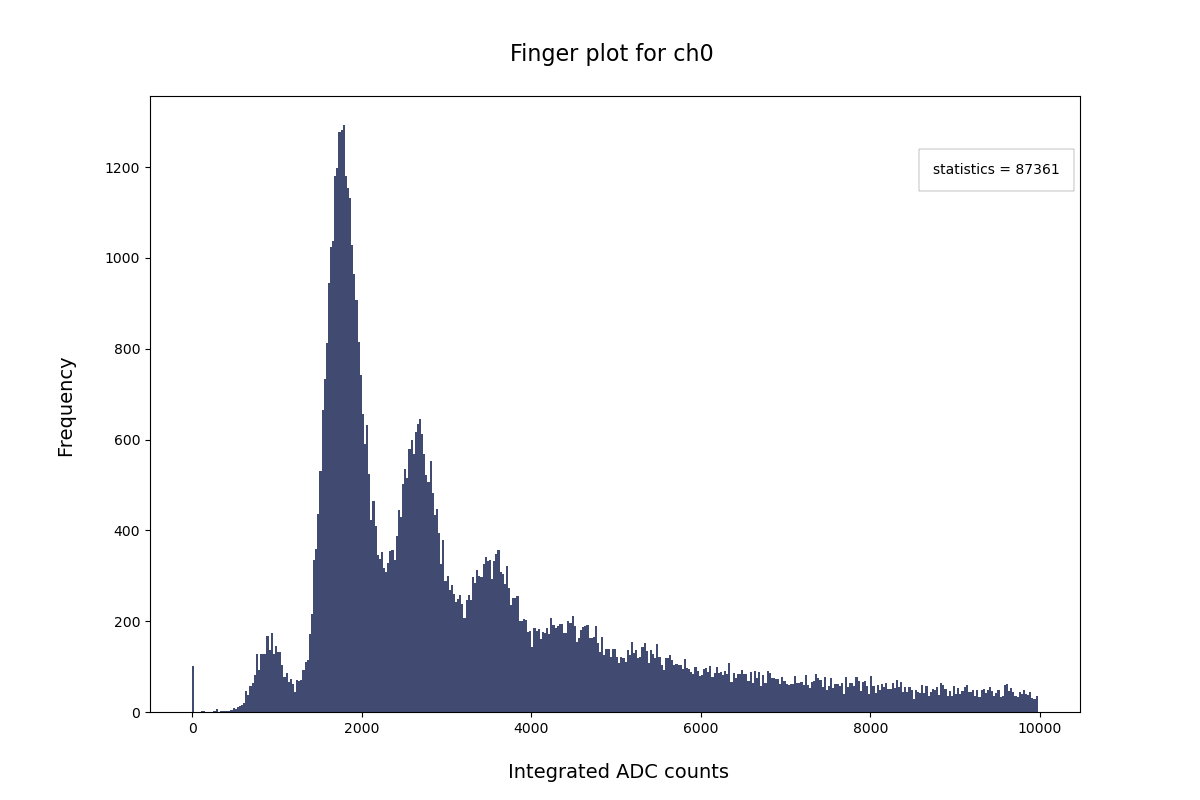

In [174]:
fig99, ax99 = plt.subplots( figsize=(12, 8))
# hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 2500, 10), color='#B5D9C0', label=ch_x); # peak_loc works for ch1
# hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 10000, 25), color='#414B71', label=ch_x); # peak_loc works for ch0
hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 10000, 25), color='#414B71', label=ch_x); # peak_loc works for ch0
# hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 2000, 20), color='#AC7774', label='ch2');
ax99.set_title(f'Finger plot for {ch_x} \n', fontsize=16)
ax99.set_xlabel('\n Integrated ADC counts')
ax99.set_ylabel('Frequency \n')
# ax99.legend(bbox_to_anchor=(1.0, 1.0))
txt_box = offsetbox.TextArea(f"statistics = {len(integration_vector)}", textprops=dict(color='black', backgroundcolor='white'))
annotation_box_artist = offsetbox.AnnotationBbox(
                        txt_box, (0.91, 0.88), frameon=True, pad=0.1, xycoords='axes fraction', 
                        bboxprops=dict(edgecolor='#2D2D2D', linewidth=0.2, boxstyle="square, pad=1.0")
                        )
ax99.add_artist(annotation_box_artist)

In [201]:
# pulse_integration_window_begin = 450
# pulse_integration_window_end = 650

integration_vector = np.array([])

for wf_index in fit_catalogue[ch_x]['wf_raw'].index.values:
    # if fit_catalogue[ch_x]['chisqr'].loc[wf_index] < 2.0:
    if True:
        fitted_param = fit_catalogue[ch_x]['fit_param'][wf_index]
        fitted_baseline = fitted_param[4]
        # trace = fit_catalogue[ch_x]['wf_raw'].loc[wf_index] - fitted_baseline
        trace = fit_catalogue[ch_x][f'filtered_wf_{ch_x}'].loc[wf_index] - fitted_baseline
        peak_loc =  int(fitted_param[0])
        # pulse_win_integration_value = np.sum(trace[pulse_integration_window_begin:pulse_integration_window_end]) # fixed window
        # pulse_win_integration_value = np.sum(trace[peak_loc-10:peak_loc+50]) # asymmetric window around peak
        pulse_win_integration_value = np.sum(trace[peak_loc-20:peak_loc+20])
        integration_vector = np.append(integration_vector, pulse_win_integration_value)

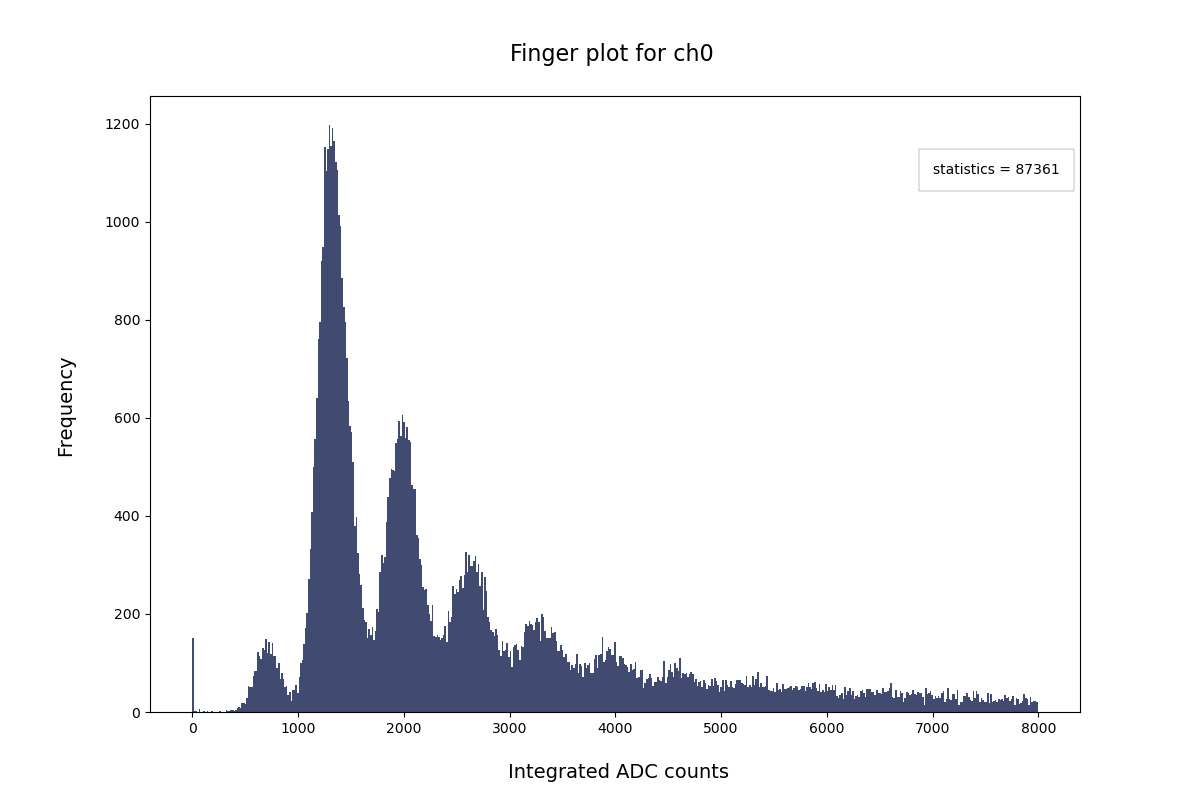

In [202]:
fig100, ax100 = plt.subplots( figsize=(12, 8))
# hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 2500, 10), color='#B5D9C0', label=ch_x); # peak_loc works for ch1
# hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 10000, 25), color='#414B71', label=ch_x); # peak_loc works for ch0
hist_content, hist_edges, _hist_obj = ax100.hist(integration_vector, bins=np.arange(0, 8000, 15), color='#414B71', label=ch_x); # peak_loc works for ch0
# hist_content, hist_edges, _hist_obj = ax99.hist(integration_vector, bins=np.arange(0, 2000, 20), color='#AC7774', label='ch2');
ax100.set_title(f'Finger plot for {ch_x} \n', fontsize=16)
ax100.set_xlabel('\n Integrated ADC counts')
ax100.set_ylabel('Frequency \n')
# ax99.legend(bbox_to_anchor=(1.0, 1.0))
txt_box = offsetbox.TextArea(f"statistics = {len(integration_vector)}", textprops=dict(color='black', backgroundcolor='white'))
annotation_box_artist = offsetbox.AnnotationBbox(
                        txt_box, (0.91, 0.88), frameon=True, pad=0.1, xycoords='axes fraction', 
                        bboxprops=dict(edgecolor='#2D2D2D', linewidth=0.2, boxstyle="square, pad=1.0")
                        )
ax100.add_artist(annotation_box_artist)

In [203]:
ax100.grid()

In [204]:
# ax100.axvline(x = 1000, linestyle='--', alpha=0.5, color='grey', label='fit range')
# ax100.axvline(x = 1725, linestyle='--', alpha=0.5, color='grey')
ax100.axvline(x = 1750, linestyle='--', alpha=0.5, color='grey')
ax100.axvline(x = 2250, linestyle='--', alpha=0.5, color='grey')

# # ax99.axvline(x = 2517, linestyle='--', color='magenta', alpha=0.5, label='mean f1')
# # ax99.axvline(x = 3770, linestyle='--', color='magenta', alpha=0.5, label='mean f2')
# ax99.legend(bbox_to_anchor=(1.0, 0.75))

In [205]:
# fig99.savefig(f'../plots/fingerplotP_filtered_{ch_x}.png')

# 11. <a id='toc11_'></a>[fit gaussian to finger](#toc0_)

## 11.1. <a id='toc11_1_'></a>[First finger](#toc0_)

In [206]:
np.where(hist_edges <= 2000)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133]),)

In [207]:
hist_edges[133
           ]

1995.0

In [208]:
# x_range = range(85, 126) ## ch0 from default

# x_range = range(85, 133) ## ch0

x_range = range(75, 100) ## ch0

# p0_input = [2500, 200, 1200.0] ## ch0
p0_input = [1300, 135, 10000.0] ## ch0

bounds_input = ([1000.0, 0.0001, 0.0001], [np.inf, np.inf, np.inf]) ## ch0

fitted_parameters, pcov = curve_fit(f_gauss, 
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input,
                            bounds = bounds_input,
                            sigma = np.sqrt(hist_content[x_range]),
                            absolute_sigma=True,
                            )

red_chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters), fitted_parameters
    )

ax100.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters), color='red', label='first fit')

red_chisqr_value

1.4797117796539896

In [209]:
fitted_parameters

array([      1316,      134.6,  4.005e+05])

In [210]:
perr = np.sqrt(np.diag(pcov))

In [211]:
perr

array([     1.305,      1.759,       3783])

## 11.2. <a id='toc11_2_'></a>[Second finger](#toc0_)

In [212]:
np.where(hist_edges <= 1750)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]),)

In [213]:
np.where(hist_edges <= 2250)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150]),)

In [214]:
# x_range = range(140, 164) ## ch0
x_range = range(116, 145) ## filtered ch0

# p0_input = [3750, 300, 100000.0] ## ch0
p0_input = [3750, 300, 100000.0] ## ch0

bounds_input = ([1000.0, 0.0001, 0.0001], [np.inf, np.inf, np.inf]) ## ch0

fitted_parameters, pcov = curve_fit(f_gauss, 
                            hist_edges[x_range], hist_content[x_range], \
                            p0 = p0_input,
                            bounds = bounds_input,
                            sigma = np.sqrt(hist_content[x_range]),
                            absolute_sigma=True,
                            )

red_chisqr_value = red_chisq(hist_content[x_range], \
    f_gauss(hist_edges[x_range], *fitted_parameters), fitted_parameters
    )

ax100.plot(hist_edges[x_range], f_gauss(hist_edges[x_range], *fitted_parameters), color='green', linewidth=2.2, label='second fit')

red_chisqr_value

1.330111886933915

In [215]:
fitted_parameters

array([      1973,      158.2,  2.324e+05])

In [216]:
## standard deviation from covariance matrix
perr = np.sqrt(np.diag(pcov))

In [217]:
perr

array([     2.094,       2.79,       2986])

# 12. <a id='toc12_'></a>[SPE charge](#toc0_)

In [218]:
## ch0
## instruction: difference of means of first two peaks
# print(f"SPE charge: {3770 - 2517}") ### ch0 from default
print(f"SPE charge: {1973 - 1316}") ### filtered ch0 from default

SPE charge: 657


In [219]:
## error in SPE charge using error propagation
# f"Error: {np.sqrt((3.377)**2 + (5.697)**2)}"
f"Error: {np.sqrt((1.305)**2 + (2.094)**2)}"  ### filtered ch0

'Error: 2.467359114519003'

# 13. <a id='toc13_'></a>[SNR](#toc0_)

In [220]:
## instruction Signal to Noise Ration (SNR) given by that SPE charge divided by Gaussian sigma of the first peak. First peak = pedestal?
## since we only have access to the second peak, you can use instead its sigma, divided by sqrt(2)
## (this is because sigma of a convolution of two identical gauss distributions is sqrt(2 * sigma^2) ) ## convolution of which distributions? why convolution?

In [221]:
# SPE_charge = 1253
# sigma_1 = 241.3
# SNR = SPE_charge/(sigma_1/np.sqrt(2))

SPE_charge = 657
sigma_1 = 134.6
SNR = SPE_charge/(sigma_1/np.sqrt(2))

f"SNR: {SNR:.2f}"

'SNR: 6.90'

<hr style="border: none; border-bottom: 5px solid blue;"> </hr>